In [0]:
 # !pip3 install mesa

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [0]:
class Modelo_1(Model):
    SEIR_susceptible=0
    SEIR_exposed=1
    SEIR_infected=2
    SEIR_recovered=3
    SEIR_death=4
    SEIR_immune=5
    Infection_days_remain_default= 14 # (d)
    def __init__(self, N, width, height,inf_n):
        if inf_n > N:
          inf_n=N
        self.num_agents = N
        self.num_agents_inf = inf_n
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        for i in range(inf_n):
          a = Agente(i,1, self)
          self.schedule.add(a)
          x = self.random.randrange(self.grid.width)
          y = self.random.randrange(self.grid.height)
          self.grid.place_agent(a, (x, y))

        for i in range(inf_n,self.num_agents,1):
          a = Agente(i,0, self)
          self.schedule.add(a)
          x = self.random.randrange(self.grid.width)
          y = self.random.randrange(self.grid.height)
          self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()
        
class Agente(Agent):
    def __init__(self, unique_id,infected,model):
        super().__init__(unique_id, model)
        self.inf_days_remain_default = model.Infection_days_remain_default
        self.wealth = 1
        self.Age = self.random.randrange(100)
        self.gender = np.round(self.random.randrange(1))
        self.r0 = np.round(self.random.randrange(2))
        self.contactos = 0
        self.infected = infected
        if self.infected:
          self.inf_days_remain = self.inf_days_remain_default
          self.SEIR_state = model.SEIR_infected
        else:
          self.inf_days_remain = 0
          self.SEIR_state = model.SEIR_susceptible

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def interaction(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates_r0 = [i.r0 for i in cellmates]
        self.r0=sum(cellmates_r0)/len(cellmates_r0)
        if self.r0 < self.random.randrange(2):
          self.infected = 1
          self.inf_days_remain = self.inf_days_remain_default
          self.SEIR_state = model.SEIR_infected

    def step(self):
        self.move()
        if self.wealth > 0:
            self.interaction()
        if self.inf_days_remain > 0:
          self.inf_days_remain -= self.inf_days_remain
        elif not self.inf_days_remain and self.infected:
          self.infected=0
          self.SEIR_state = model.SEIR_recovered

In [0]:
model = Modelo_1(50, 10, 10,1)
for i in range(2):
    model.step()

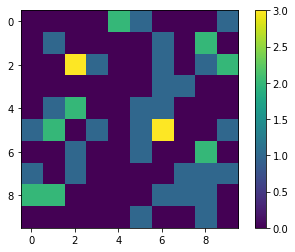

In [29]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()